In [1]:
import numpy as np, matplotlib.pyplot as plt
import matelms as me
from krypy.linsys import LinearSystem, Gmres
from scipy.sparse.linalg import gmres, bicgstab, LinearOperator

In [2]:
PI = 3.14159265359
b, eta = 1.0, 0.1
xij,yij,zij = np.array([-2.0040735703833774, 0., 0.])

Assemble two-body GHH and test it on a system Ax=b with b=Ae, where e is a vector of ones

In [3]:
##diagonal matrix elements
g2s = np.full(5, 3./(20*PI*eta*b))
g3t = np.full(3, 1./(2*PI*eta*b))
g3a = np.full(5, 3./(2*PI*eta*b))
g3s = np.full(7, 6./(7*PI*eta*b))

GoHH = np.diag(np.block([g2s,g3t,g3a,g3s]))

##construct two-body GHH, dimension 40x40
def GHH(xij,yij,zij):
    return np.block([[GoHH, me.GHH(xij,yij,zij, b,eta)],
                    [me.GHH(-xij,-yij,-zij, b,eta), GoHH]])

First, test how normal solution of linear system behaves: can solve it, apart from at zero

In [4]:
%%time
interval = np.arange(-2.5,6.5,0.01)
soln  = np.zeros(interval.shape[0])
j=0
for i in interval:
    rhs = np.dot(GHH(xij+i,yij,zij),np.ones(40)) 
    soln[j] = np.linalg.norm(np.linalg.solve(GHH(xij+i,yij,zij), rhs))
    j+=1
    
exact_soln = np.full(interval.shape[0], np.linalg.norm(np.ones(40)))

CPU times: user 49.2 s, sys: 45.2 s, total: 1min 34s
Wall time: 12.1 s


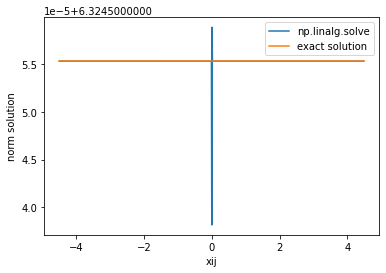

In [5]:
plt.plot(xij+interval, soln, label='np.linalg.solve')
plt.plot(xij+interval, exact_soln, label='exact solution') 
plt.xlabel('xij')
plt.ylabel('norm solution')
plt.legend()
plt.show()

Test krypy - how many iterations do we need with an uninformed initial guess? 12 iterations

In [6]:
A = GHH(xij,yij,zij)
rhs = np.dot(GHH(xij,yij,zij),np.ones(40)) 


linear_system = LinearSystem(A, rhs)
solver = Gmres(linear_system, maxiter=None, tol=1e-5)
solver

krypy GMRES object
    MMlr0 = [[0.56786721], ..., [2.78989591]]
    MMlr0_norm = 18.754632664779887
    MlAMr: 40 x 40 matrix
    Mlr0: [[0.56786721], ..., [2.78989591]]
    R: 41 x 40 matrix
    V: 40 x 41 matrix
    flat_vecs: True
    store_arnoldi: False
    ortho: mgs
    tol: 1e-05
    maxiter: 40
    iter: 12
    explicit residual: False
    resnorms: [1.0, ..., 4.375246898693988e-06]
    x0: [[0.], ..., [0.]]
    xk: [[1.00000851], ..., [1.00000228]]

With no max iter and restarts (gmres) given, which is quicker: GMRES or BiCGSTAB? (scipy, because easier to use and A(x) can be a linear operator)

In [7]:
sol = np.linalg.norm(bicgstab(GHH(xij+i,yij,zij), rhs, x0=None, maxiter=None)[0])

In [8]:
%%time
interval = np.arange(-2.5,6.5,0.01)
soln  = np.zeros(interval.shape[0])
j=0
for i in interval:
    rhs = np.dot(GHH(xij+i,yij,zij),np.ones(40)) 
    soln[j] = np.linalg.norm(bicgstab(GHH(xij+i,yij,zij), rhs, x0=None, maxiter=None)[0])
    j+=1

CPU times: user 5.7 s, sys: 157 µs, total: 5.7 s
Wall time: 5.7 s


In [9]:
%%time
interval = np.arange(-2.5,6.5,0.01)
soln_gmres  = np.zeros(interval.shape[0])
j=0
for i in interval:
    rhs = np.dot(GHH(xij+i,yij,zij),np.ones(40)) 
    soln_gmres[j] = np.linalg.norm(gmres(GHH(xij+i,yij,zij), rhs, x0=None, maxiter=None)[0])
    j+=1

CPU times: user 11.5 s, sys: 18.4 ms, total: 11.5 s
Wall time: 11.5 s


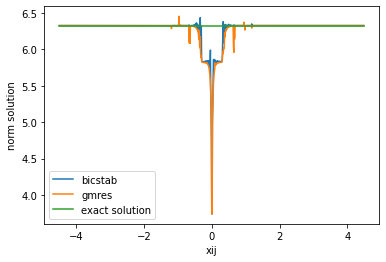

In [10]:
plt.plot(xij+interval, soln, label='bicstab')
plt.plot(xij+interval, soln_gmres, label='gmres')
plt.plot(xij+interval, exact_soln, label='exact solution') 
plt.xlabel('xij')
plt.ylabel('norm solution')
plt.legend()
plt.show()

For speed, use BiCSTAB. Check its convergence with number of iterations

In [11]:
iterations = np.arange(0,20)
rres = np.zeros(iterations.shape[0]) ##relative residuals

rhs = np.dot(GHH(xij,yij,zij),np.ones(40)) 

for i in iterations:
    sol = bicgstab(GHH(xij,yij,zij), rhs, maxiter=i+1)[0]
    rres[i] = np.linalg.norm((rhs-np.dot(GHH(xij,yij,zij), sol)))/np.linalg.norm(rhs)

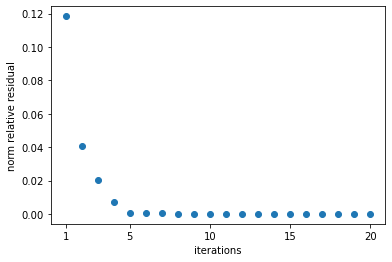

In [12]:
plt.plot(iterations+1, rres, 'o') #plot relative residual
plt.ylabel('norm relative residual')
plt.xlabel('iterations')
plt.xticks((1, 5, 10, 15, 20))
plt.show()

Use Ax as linear operator for krylov solver

In [13]:
def GHHFH(FH):
    return np.dot(GHH(xij,yij,zij), FH)

In [14]:
rhs = np.dot(GHH(xij,yij,zij),np.ones(40)) 
Ax = LinearOperator((40,40),matvec=GHHFH) ##Ax as linear operator

soln, exitCode = bicgstab(Ax, rhs)

In [15]:
np.linalg.norm(soln - np.ones(40))

0.00021486723966246721

With informed starting point: How does the number of needed iterations and the result behave?

In [16]:
sol0 = np.diag(GHH(xij,yij,zij)) ##element-wise

In [17]:
iterations = np.arange(0,10)
rres_init = np.zeros(iterations.shape[0]) ##relative residuals of informed iteration

rhs = np.dot(GHH(xij,yij,zij),np.ones(40)) 

for i in iterations:
    sol = bicgstab(GHH(xij,yij,zij), rhs, maxiter=i+1, x0=sol0)[0]
    rres_init[i] = np.linalg.norm((rhs-np.dot(GHH(xij,yij,zij), sol)))/np.linalg.norm(rhs)

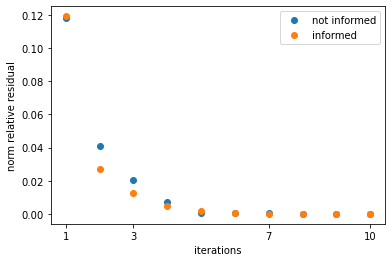

In [18]:
plt.plot(iterations+1, rres[:10], 'o', label='not informed') #plot relative residual
plt.plot(iterations+1, rres_init, 'o', label='informed')
plt.ylabel('norm relative residual')
plt.xlabel('iterations')
plt.xticks((1, 3, 7, 10))
plt.legend()
plt.show()

Time and quality of solutions with and without informed starting point: equally fast and does not seem to change behaviour much.

In [19]:
%%time
interval = np.arange(-2.5,6.5,0.01)
soln  = np.zeros(interval.shape[0])
j=0
for i in interval:
    rhs = np.dot(GHH(xij+i,yij,zij),np.ones(40)) 
    soln[j] = np.linalg.norm(bicgstab(GHH(xij+i,yij,zij), rhs, x0=None, maxiter=None)[0])
    j+=1

CPU times: user 5.81 s, sys: 18.1 ms, total: 5.83 s
Wall time: 5.82 s


In [20]:
%%time
interval = np.arange(-2.5,6.5,0.01)
soln_init  = np.zeros(interval.shape[0])
j=0
for i in interval:
    rhs = np.dot(GHH(xij+i,yij,zij),np.ones(40)) 
    soln_init[j] = np.linalg.norm(bicgstab(GHH(xij+i,yij,zij), rhs, x0=sol0, maxiter=None)[0])
    j+=1

CPU times: user 5.8 s, sys: 6.97 ms, total: 5.81 s
Wall time: 5.81 s


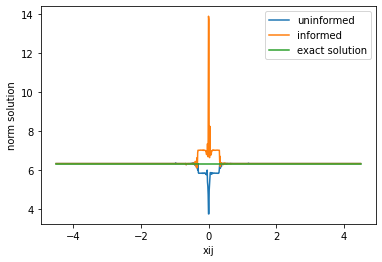

In [21]:
plt.plot(xij+interval, soln, label='uninformed')
plt.plot(xij+interval, soln_init, label='informed')
plt.plot(xij+interval, exact_soln, label='exact solution') 
plt.xlabel('xij')
plt.ylabel('norm solution')
plt.legend()
plt.show()

To Do:
    
    - Make sure to understand implementation
    - Re-implement the Mathematica code in a functional form
    - Implement the linear solver